In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Airline stocks

### Hawaiian Holdings, Inc (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/HA_data.csv")
print(df.head())

         Date  previous_1d    EMA_12    willr_14     OBV_7  labels
0  2000-01-21       2.0625  2.055042  -66.666667  186300.0     2.0
1  2000-01-24       2.0000  2.046574 -100.000000  173400.0     2.0
2  2000-01-25       1.9375  2.029793 -100.000000  105600.0     2.0
3  2000-01-26       1.9375  2.015594  -75.000000  105600.0     2.0
4  2000-01-27       2.0000  2.013195  -50.000000  121200.0     2.0


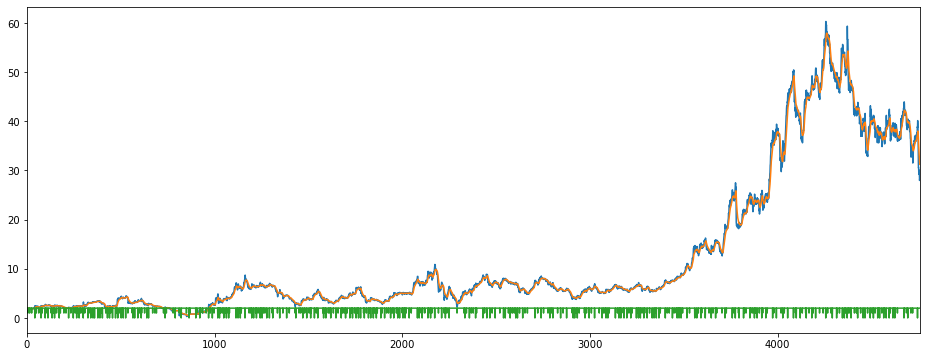

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,2.0625,2.055042,-66.666667,186300.0,2.0
2000-01-24,2.0000,2.046574,-100.000000,173400.0,2.0
2000-01-25,1.9375,2.029793,-100.000000,105600.0,2.0
2000-01-26,1.9375,2.015594,-75.000000,105600.0,2.0
2000-01-27,2.0000,2.013195,-50.000000,121200.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

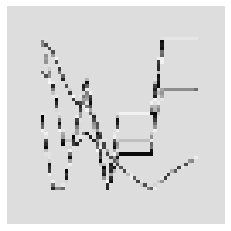

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 8.0084388185654, 1: 7.3140655105973025, 2: 0.36517556517556515}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.2577 - accuracy: 0.6797 - mse: 5.5551 - weighted_accuracy: 0.4311 - weighted_mse: 5.7959WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 22ms/step - loss: 0.2424 - accuracy: 0.3646 - mse: 1.6310 - weighted_accuracy: 0.3228 - weighted_mse: 1.6466 - val_loss: 0.2424 - val_accuracy: 0.0453 - val_mse: 1.0050 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 1.0050
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2087 - accuracy: 0.1520 - mse: 1.2483 - weighted_accuracy: 0.3257 - weighted_mse: 1.1870 - val_loss: 0.2065 - val_accuracy: 0.0453 - val

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.2584 - mse: 1.2217 - weighted_accuracy: 0.4345 - weighted_mse: 1.1831 - val_loss: 0.1984 - val_accuracy: 0.0759 - val_mse: 1.1428 - val_weighted_accuracy: 0.0759 - val_weighted_mse: 1.1428
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1918 - accuracy: 0.2516 - mse: 1.2190 - weighted_accuracy: 0.4505 - weighted_mse: 1.2054 - val_loss: 0.2020 - val_accuracy: 0.0738 - val_mse: 1.0831 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0831
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1892 - accuracy: 0.2445 - mse: 1.2458 - weighted_accuracy: 0.4678 - weighted_mse: 1.2221 - val_loss: 0.2015 - val_accuracy: 0.0643 - val_mse: 1.0846 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 1.0846
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1915 - accuracy: 0.2845 - mse: 1.2050 - weighted_accuracy: 0.4422 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.1841 - mse: 1.4246 - weighted_accuracy: 0.5781 - weighted_mse: 1.3816 - val_loss: 0.2051 - val_accuracy: 0.0854 - val_mse: 1.1378 - val_weighted_accuracy: 0.0854 - val_weighted_mse: 1.1378
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1681 - accuracy: 0.1818 - mse: 1.3858 - weighted_accuracy: 0.5674 - weighted_mse: 1.3399 - val_loss: 0.2032 - val_accuracy: 0.0927 - val_mse: 1.2021 - val_weighted_accuracy: 0.0927 - val_weighted_mse: 1.2021
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1682 - accuracy: 0.1715 - mse: 1.3640 - weighted_accuracy: 0.5622 - weighted_mse: 1.3494 - val_loss: 0.2052 - val_accuracy: 0.0948 - val_mse: 1.1491 - val_weighted_accuracy: 0.0948 - val_weighted_mse: 1.1491
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1690 - accuracy: 0.1620 - mse: 1.3407 - weighted_accuracy: 0.5767 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1448 - accuracy: 0.2439 - mse: 1.5635 - weighted_accuracy: 0.6697 - weighted_mse: 1.6103 - val_loss: 0.2012 - val_accuracy: 0.1760 - val_mse: 1.5075 - val_weighted_accuracy: 0.1760 - val_weighted_mse: 1.5075
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1465 - accuracy: 0.2397 - mse: 1.5896 - weighted_accuracy: 0.6468 - weighted_mse: 1.6235 - val_loss: 0.2013 - val_accuracy: 0.1718 - val_mse: 1.3717 - val_weighted_accuracy: 0.1718 - val_weighted_mse: 1.3717
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.2471 - mse: 1.5996 - weighted_accuracy: 0.6626 - weighted_mse: 1.6338 - val_loss: 0.2013 - val_accuracy: 0.1907 - val_mse: 1.3674 - val_weighted_accuracy: 0.1907 - val_weighted_mse: 1.3674
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1472 - accuracy: 0.2487 - mse: 1.5519 - weighted_accuracy: 0.6354 - weig

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1282 - accuracy: 0.3844 - mse: 1.8450 - weighted_accuracy: 0.7190 - weighted_mse: 2.1043 - val_loss: 0.1941 - val_accuracy: 0.3288 - val_mse: 1.6965 - val_weighted_accuracy: 0.3288 - val_weighted_mse: 1.6965
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1277 - accuracy: 0.3807 - mse: 1.8733 - weighted_accuracy: 0.7262 - weighted_mse: 2.1038 - val_loss: 0.1919 - val_accuracy: 0.3562 - val_mse: 1.7105 - val_weighted_accuracy: 0.3562 - val_weighted_mse: 1.7105
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1253 - accuracy: 0.4038 - mse: 1.8751 - weighted_accuracy: 0.7312 - weighted_mse: 2.1410 - val_loss: 0.1886 - val_accuracy: 0.3625 - val_mse: 1.7327 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.7327
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1277 - accuracy: 0.4023 - mse: 1.8713 - weighted_accuracy: 0.7233 - 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1096 - accuracy: 0.5730 - mse: 2.2258 - weighted_accuracy: 0.7877 - weighted_mse: 3.0018 - val_loss: 0.1583 - val_accuracy: 0.5964 - val_mse: 2.0159 - val_weighted_accuracy: 0.5964 - val_weighted_mse: 2.0159
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1077 - accuracy: 0.5975 - mse: 2.3068 - weighted_accuracy: 0.7948 - weighted_mse: 3.1290 - val_loss: 0.1647 - val_accuracy: 0.5606 - val_mse: 1.9596 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 1.9596
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1055 - accuracy: 0.6062 - mse: 2.3144 - weighted_accuracy: 0.8190 - weighted_mse: 3.1244 - val_loss: 0.1595 - val_accuracy: 0.6101 - val_mse: 2.2156 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 2.2156
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1090 - accuracy: 0.5780 - mse: 2.3548 - weighted_accuracy: 0.7968 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0940 - accuracy: 0.7028 - mse: 2.9903 - weighted_accuracy: 0.8208 - weighted_mse: 4.6197 - val_loss: 0.1410 - val_accuracy: 0.6944 - val_mse: 2.5331 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 2.5331
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0929 - accuracy: 0.7055 - mse: 2.9662 - weighted_accuracy: 0.8295 - weighted_mse: 4.5836 - val_loss: 0.1293 - val_accuracy: 0.7429 - val_mse: 2.3501 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 2.3501
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0881 - accuracy: 0.7300 - mse: 2.8992 - weighted_accuracy: 0.8446 - weighted_mse: 4.6187 - val_loss: 0.1321 - val_accuracy: 0.7302 - val_mse: 2.4393 - val_weighted_accuracy: 0.7302 - val_weighted_mse: 2.4393
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0899 - accuracy: 0.7126 - mse: 2.9751 - weighted_accuracy: 0.8414 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12541615962982178
Test accuracy: 0.767123281955719


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8927968  -1.724889    0.01027127]
 [-1.4023283  -1.6470969   0.05877752]
 [-2.2721841  -1.3721795  -0.02780495]
 ...
 [-2.860133   -1.0498152  -0.07283445]
 [-0.5588981  -2.709481   -0.3446795 ]
 [-2.7243128  -0.07699852 -0.5743296 ]]


Counter({2: 780, 1: 125, 0: 44})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 39, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 12
actual buys but predicted sell: 1
actual buys but predicted hold: 30
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 36
actual holds but predicted buy: 112
actual holds but predicted sell: 41
actual predicted holds: 714
Percentage buys correct: 27.906976744186046%
Percentage sells correct: 5.128205128205129%
Percentage holds correct: 82.3529411764706%
actual buys: 43
actual sells: 39
actual holds: 867


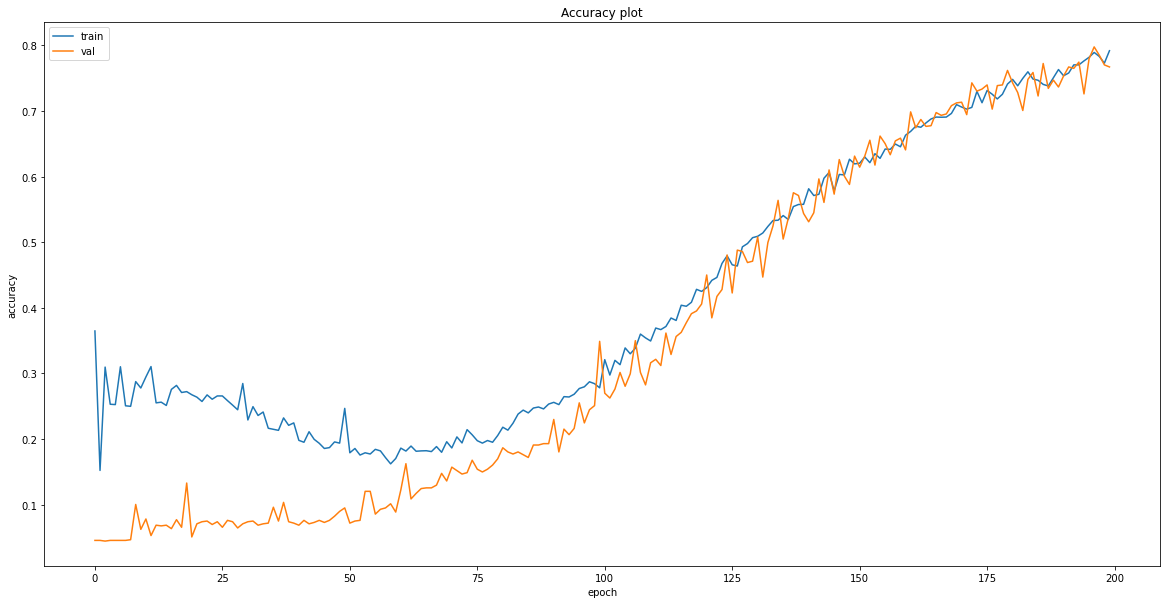

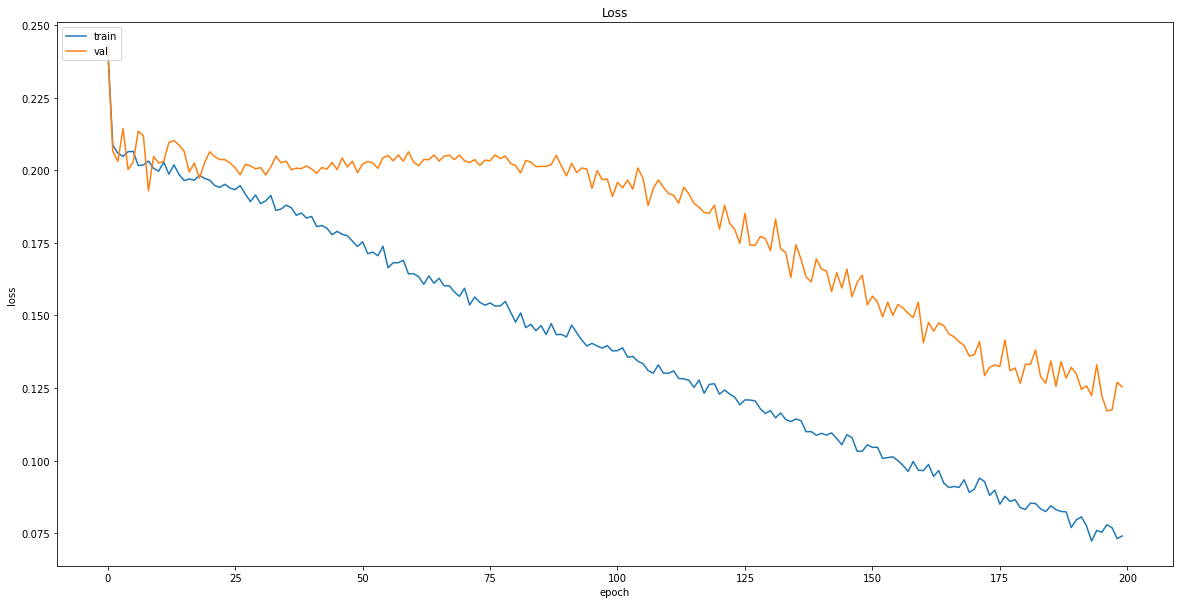

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('HA_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/HA_image_cnn_buy_hold_sell.model\assets


### JetBlue Airways Corporation (Mid Cap)

In [28]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JBLU_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
1  2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2  2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
3  2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
4  2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


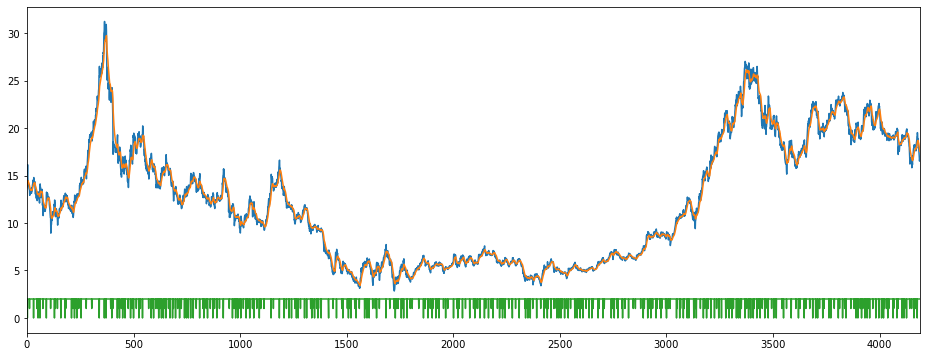

In [29]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4175, 64, 64, 1)

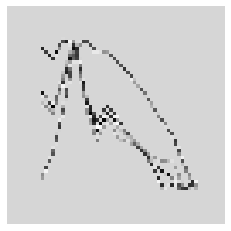

In [36]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [37]:
X = X/255

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}
Epoch 1/200
27/27 [==============================] - 2s 56ms/step - loss: 0.2492 - accuracy: 0.3204 - mse: 1.6919 - weighted_accuracy: 0.3244 - weighted_mse: 1.6947 - val_loss: 0.1894 - val_accuracy: 0.5102 - val_mse: 1.0867 - val_weighted_accuracy: 0.5102 - val_weighted_mse: 1.0867
Epoch 2/200
27/27 [==============================] - 0s 9ms/step - loss: 0.2111 - accuracy: 0.2470 - mse: 1.2565 - weighted_accuracy: 0.3291 - weighted_mse: 1.2693 - val_loss: 0.1859 - val_accuracy: 0.8192 - val_mse: 1.0145 - val_weighted_accuracy: 0.8192 - val_weighted_mse: 1.0145
Epoch 3/200
27/27 [==============================] - 0s 9ms/step - loss: 0.2097 - accuracy: 0.2237 - mse: 1.1240 - weighted_accuracy: 0.3353 - weighted_mse: 1.1162 - val_loss: 0.2076 - val_accuracy: 0.0443 - val_mse: 1.0454 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 1.0454
Epoch 4/200
27/27 [==============================] - 0s 9ms/step - loss: 0.2075 -

27/27 [==============================] - 0s 9ms/step - loss: 0.1849 - accuracy: 0.2368 - mse: 1.2690 - weighted_accuracy: 0.5141 - weighted_mse: 1.2121 - val_loss: 0.1861 - val_accuracy: 0.3102 - val_mse: 1.1170 - val_weighted_accuracy: 0.3102 - val_weighted_mse: 1.1170
Epoch 29/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1860 - accuracy: 0.2787 - mse: 1.3473 - weighted_accuracy: 0.4985 - weighted_mse: 1.2812 - val_loss: 0.1991 - val_accuracy: 0.1437 - val_mse: 1.1669 - val_weighted_accuracy: 0.1437 - val_weighted_mse: 1.1669
Epoch 30/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1847 - accuracy: 0.2985 - mse: 1.3613 - weighted_accuracy: 0.4992 - weighted_mse: 1.3163 - val_loss: 0.1876 - val_accuracy: 0.2862 - val_mse: 1.2221 - val_weighted_accuracy: 0.2862 - val_weighted_mse: 1.2221
Epoch 31/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1750 - accuracy: 0.3419 - mse: 1.3862 - weighted_accuracy: 0.5454 - weighted_mse: 1.3

Epoch 57/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1574 - accuracy: 0.3201 - mse: 1.4357 - weighted_accuracy: 0.6414 - weighted_mse: 1.4163 - val_loss: 0.1872 - val_accuracy: 0.3222 - val_mse: 1.1824 - val_weighted_accuracy: 0.3222 - val_weighted_mse: 1.1824
Epoch 58/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1585 - accuracy: 0.3308 - mse: 1.5328 - weighted_accuracy: 0.6185 - weighted_mse: 1.5014 - val_loss: 0.1957 - val_accuracy: 0.2000 - val_mse: 1.2618 - val_weighted_accuracy: 0.2000 - val_weighted_mse: 1.2618
Epoch 59/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1550 - accuracy: 0.3329 - mse: 1.5162 - weighted_accuracy: 0.6629 - weighted_mse: 1.4744 - val_loss: 0.1896 - val_accuracy: 0.2695 - val_mse: 1.3180 - val_weighted_accuracy: 0.2695 - val_weighted_mse: 1.3180
Epoch 60/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1608 - accuracy: 0.3386 - mse: 1.5062 - weighted_accuracy: 0.6179 - weig

27/27 [==============================] - 0s 9ms/step - loss: 0.1395 - accuracy: 0.4249 - mse: 1.6368 - weighted_accuracy: 0.7098 - weighted_mse: 1.6456 - val_loss: 0.1819 - val_accuracy: 0.4192 - val_mse: 1.4257 - val_weighted_accuracy: 0.4192 - val_weighted_mse: 1.4257
Epoch 86/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1355 - accuracy: 0.4461 - mse: 1.7799 - weighted_accuracy: 0.7322 - weighted_mse: 1.7635 - val_loss: 0.1865 - val_accuracy: 0.3653 - val_mse: 1.3872 - val_weighted_accuracy: 0.3653 - val_weighted_mse: 1.3872
Epoch 87/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1391 - accuracy: 0.3889 - mse: 1.6795 - weighted_accuracy: 0.7006 - weighted_mse: 1.7120 - val_loss: 0.1789 - val_accuracy: 0.4467 - val_mse: 1.5825 - val_weighted_accuracy: 0.4467 - val_weighted_mse: 1.5825
Epoch 88/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1393 - accuracy: 0.4515 - mse: 1.6802 - weighted_accuracy: 0.7215 - weighted_mse: 1.7

Epoch 114/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1101 - accuracy: 0.6018 - mse: 1.9626 - weighted_accuracy: 0.8182 - weighted_mse: 2.2170 - val_loss: 0.1609 - val_accuracy: 0.5952 - val_mse: 1.6794 - val_weighted_accuracy: 0.5952 - val_weighted_mse: 1.6794
Epoch 115/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1127 - accuracy: 0.5946 - mse: 1.9206 - weighted_accuracy: 0.8007 - weighted_mse: 2.1325 - val_loss: 0.1646 - val_accuracy: 0.5737 - val_mse: 1.5923 - val_weighted_accuracy: 0.5737 - val_weighted_mse: 1.5923
Epoch 116/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1151 - accuracy: 0.5943 - mse: 1.8291 - weighted_accuracy: 0.7905 - weighted_mse: 2.0415 - val_loss: 0.1720 - val_accuracy: 0.5305 - val_mse: 1.6749 - val_weighted_accuracy: 0.5305 - val_weighted_mse: 1.6749
Epoch 117/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1166 - accuracy: 0.5907 - mse: 1.8743 - weighted_accuracy: 0.7742 -

Epoch 143/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0866 - accuracy: 0.7054 - mse: 2.3540 - weighted_accuracy: 0.8646 - weighted_mse: 2.9625 - val_loss: 0.1456 - val_accuracy: 0.6731 - val_mse: 1.8844 - val_weighted_accuracy: 0.6731 - val_weighted_mse: 1.8844
Epoch 144/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0847 - accuracy: 0.7219 - mse: 2.3567 - weighted_accuracy: 0.8624 - weighted_mse: 2.9114 - val_loss: 0.1287 - val_accuracy: 0.7605 - val_mse: 1.7224 - val_weighted_accuracy: 0.7605 - val_weighted_mse: 1.7224
Epoch 145/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0876 - accuracy: 0.7314 - mse: 2.4006 - weighted_accuracy: 0.8535 - weighted_mse: 2.9273 - val_loss: 0.1724 - val_accuracy: 0.5868 - val_mse: 1.7503 - val_weighted_accuracy: 0.5868 - val_weighted_mse: 1.7503
Epoch 146/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0933 - accuracy: 0.6671 - mse: 2.0664 - weighted_accuracy: 0.8463 - 

Epoch 172/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0662 - accuracy: 0.8078 - mse: 3.0719 - weighted_accuracy: 0.9023 - weighted_mse: 3.9683 - val_loss: 0.1325 - val_accuracy: 0.7377 - val_mse: 2.1804 - val_weighted_accuracy: 0.7377 - val_weighted_mse: 2.1804
Epoch 173/200
27/27 [==============================] - 0s 10ms/step - loss: 0.0658 - accuracy: 0.7889 - mse: 2.8998 - weighted_accuracy: 0.8995 - weighted_mse: 3.7657 - val_loss: 0.1211 - val_accuracy: 0.7868 - val_mse: 2.2330 - val_weighted_accuracy: 0.7868 - val_weighted_mse: 2.2330
Epoch 174/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0668 - accuracy: 0.7895 - mse: 2.9108 - weighted_accuracy: 0.8935 - weighted_mse: 3.8683 - val_loss: 0.1259 - val_accuracy: 0.7701 - val_mse: 2.2311 - val_weighted_accuracy: 0.7701 - val_weighted_mse: 2.2311
Epoch 175/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0718 - accuracy: 0.7841 - mse: 2.5525 - weighted_accuracy: 0.8958 -

In [43]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11137107014656067
Test accuracy: 0.8347305655479431


In [44]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3326749  -2.01262     0.50439954]
 [-1.5319271  -1.3696918   0.48474368]
 [-1.0481117  -2.616877    0.34741083]
 ...
 [-1.8717339  -1.7376592   0.5972538 ]
 [-0.25426808 -2.5637422  -0.32991117]
 [-1.2065032  -2.2811813   0.48218676]]


Counter({2: 766, 1: 28, 0: 41})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 760, 1: 37, 0: 38})

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 835
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 36
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 36
actual holds but predicted buy: 27
actual holds but predicted sell: 39
actual predicted holds: 694
Percentage buys correct: 2.7027027027027026%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 91.3157894736842%
actual buys: 37
actual sells: 38
actual holds: 760


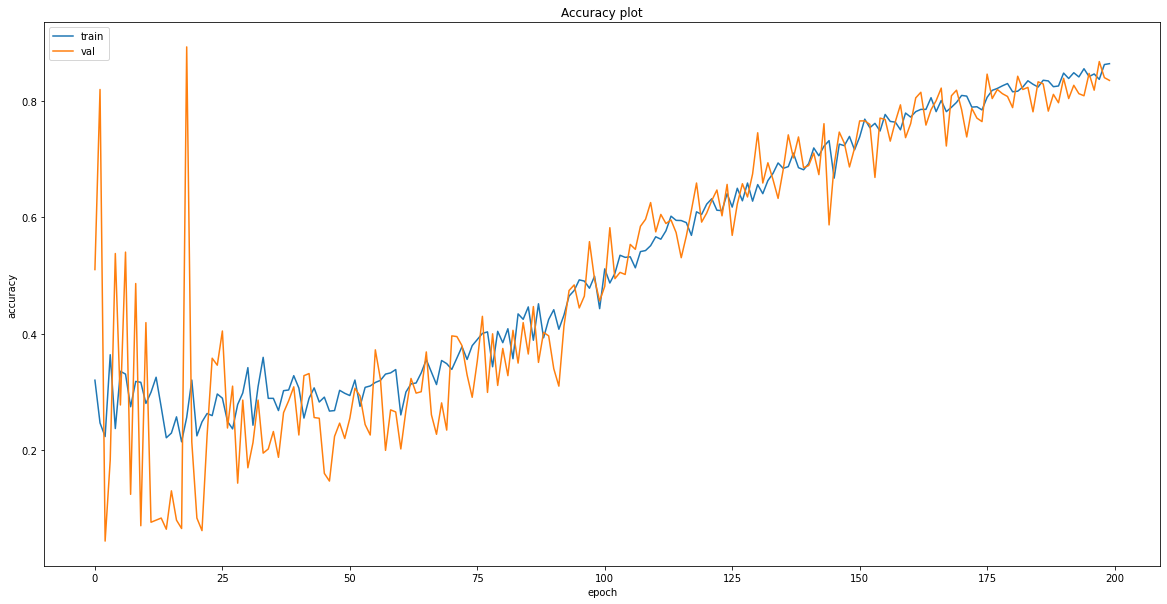

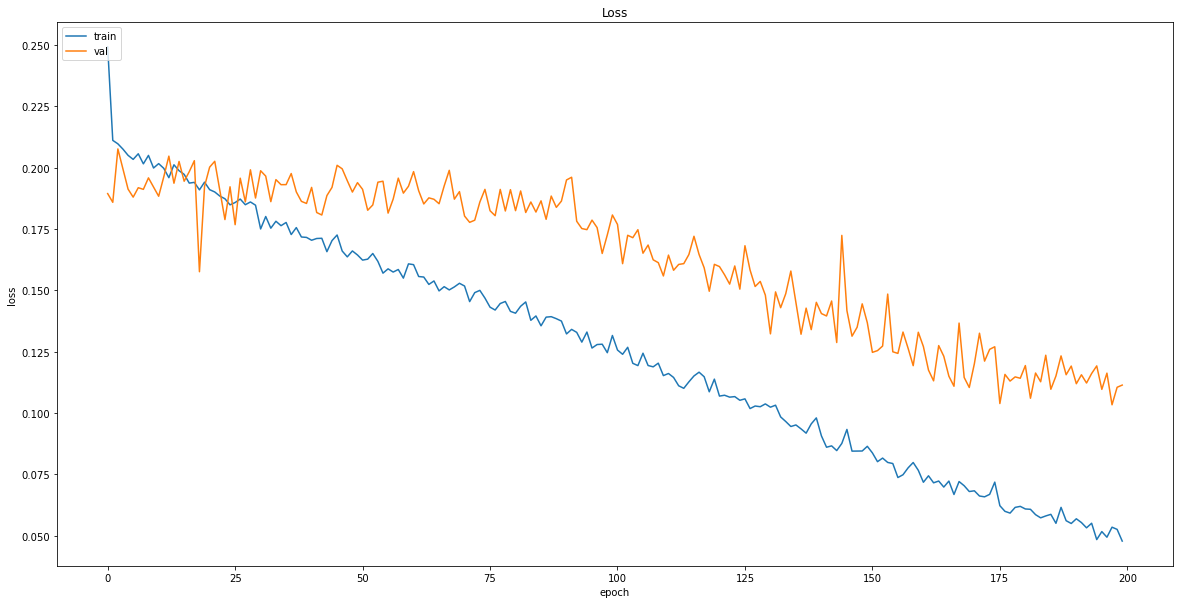

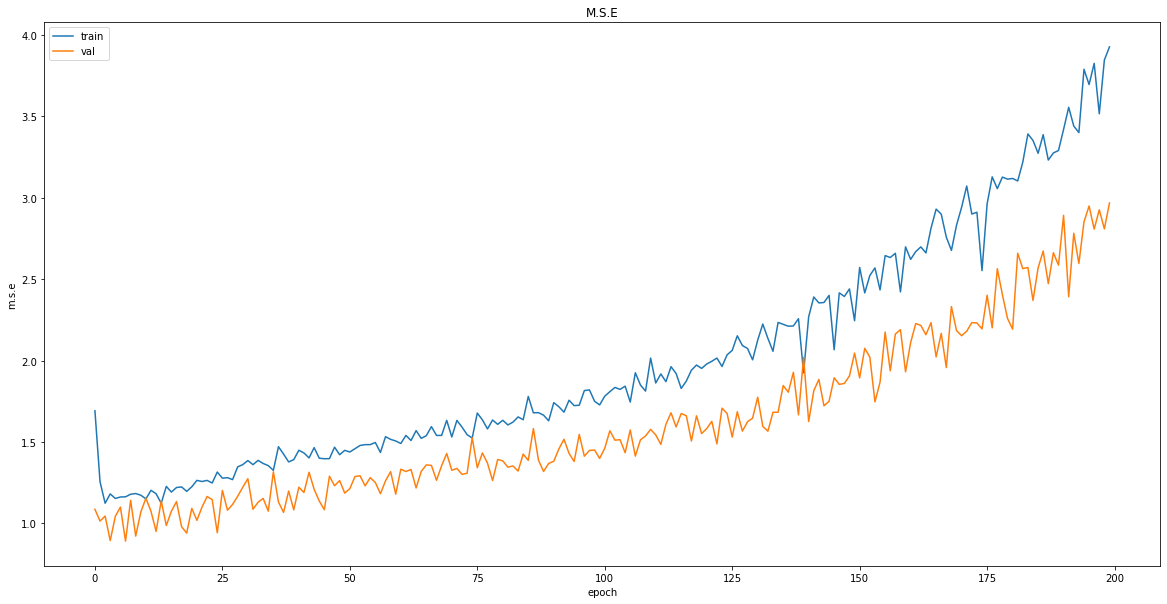

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Save model
model.save("models/{}".format('JBLU_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JBLU_image_cnn_buy_hold_sell.model\assets


## American Airlines Group Inc.  (Large Cap)

In [49]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AAL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2005-10-17    22.270000  21.619546 -18.717939  12563700.0     2.0
1  2005-10-18    22.080000  21.690385 -24.210533  12099700.0     2.0
2  2005-10-19    21.490000  21.659557 -52.068980  10284200.0     2.0
3  2005-10-20    21.379999  21.616548 -57.446844   8818200.0     1.0
4  2005-10-21    21.020000  21.524771 -92.093018   8177300.0     2.0


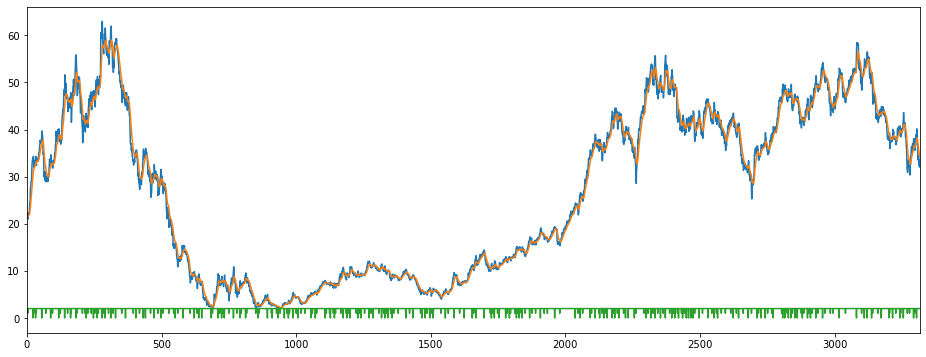

In [50]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2005-10-17,22.270000,21.619546,-18.717939,12563700.0,2.0
2005-10-18,22.080000,21.690385,-24.210533,12099700.0,2.0
2005-10-19,21.490000,21.659557,-52.068980,10284200.0,2.0
2005-10-20,21.379999,21.616548,-57.446844,8818200.0,1.0
2005-10-21,21.020000,21.524771,-92.093018,8177300.0,2.0


In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3303, 64, 64, 1)

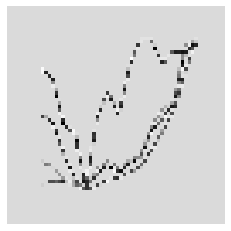

In [56]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [57]:
X = X/255

In [58]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [59]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [60]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [62]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.863095238095238, 1: 7.793510324483776, 2: 0.3643635360639912}
Epoch 1/200
21/21 [==============================] - 1s 71ms/step - loss: 0.2438 - accuracy: 0.4542 - mse: 1.7696 - weighted_accuracy: 0.3887 - weighted_mse: 1.8419 - val_loss: 0.2038 - val_accuracy: 0.0424 - val_mse: 0.8787 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.8787
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 0.2083 - accuracy: 0.2782 - mse: 1.1770 - weighted_accuracy: 0.3128 - weighted_mse: 1.1676 - val_loss: 0.1950 - val_accuracy: 0.4251 - val_mse: 0.8693 - val_weighted_accuracy: 0.4251 - val_weighted_mse: 0.8693
Epoch 3/200
21/21 [==============================] - 0s 9ms/step - loss: 0.2034 - accuracy: 0.4141 - mse: 1.1631 - weighted_accuracy: 0.3594 - weighted_mse: 1.2038 - val_loss: 0.1877 - val_accuracy: 0.9092 - val_mse: 0.8930 - val_weighted_accuracy: 0.9092 - val_weighted_mse: 0.8930
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 0.2045 

21/21 [==============================] - 0s 9ms/step - loss: 0.1987 - accuracy: 0.3100 - mse: 1.1600 - weighted_accuracy: 0.3925 - weighted_mse: 1.1623 - val_loss: 0.2017 - val_accuracy: 0.0605 - val_mse: 0.9835 - val_weighted_accuracy: 0.0605 - val_weighted_mse: 0.9835
Epoch 29/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1980 - accuracy: 0.2945 - mse: 1.1823 - weighted_accuracy: 0.4236 - weighted_mse: 1.1584 - val_loss: 0.1985 - val_accuracy: 0.0908 - val_mse: 0.9330 - val_weighted_accuracy: 0.0908 - val_weighted_mse: 0.9330
Epoch 30/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1993 - accuracy: 0.2998 - mse: 1.1746 - weighted_accuracy: 0.3665 - weighted_mse: 1.1658 - val_loss: 0.2005 - val_accuracy: 0.0605 - val_mse: 1.0736 - val_weighted_accuracy: 0.0605 - val_weighted_mse: 1.0736
Epoch 31/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1977 - accuracy: 0.2793 - mse: 1.1773 - weighted_accuracy: 0.4013 - weighted_mse: 1.1

Epoch 57/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1825 - accuracy: 0.2014 - mse: 1.2561 - weighted_accuracy: 0.4916 - weighted_mse: 1.2023 - val_loss: 0.1932 - val_accuracy: 0.0681 - val_mse: 1.1298 - val_weighted_accuracy: 0.0681 - val_weighted_mse: 1.1298
Epoch 58/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1833 - accuracy: 0.1942 - mse: 1.3056 - weighted_accuracy: 0.4888 - weighted_mse: 1.2598 - val_loss: 0.1980 - val_accuracy: 0.0696 - val_mse: 1.0694 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 1.0694
Epoch 59/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1866 - accuracy: 0.1783 - mse: 1.2213 - weighted_accuracy: 0.4718 - weighted_mse: 1.1792 - val_loss: 0.1975 - val_accuracy: 0.0726 - val_mse: 0.9946 - val_weighted_accuracy: 0.0726 - val_weighted_mse: 0.9946
Epoch 60/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.1813 - mse: 1.2612 - weighted_accuracy: 0.5238 - weig

Epoch 86/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1627 - accuracy: 0.1881 - mse: 1.3718 - weighted_accuracy: 0.5743 - weighted_mse: 1.3474 - val_loss: 0.1938 - val_accuracy: 0.1452 - val_mse: 1.1187 - val_weighted_accuracy: 0.1452 - val_weighted_mse: 1.1187
Epoch 87/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1673 - accuracy: 0.1787 - mse: 1.3300 - weighted_accuracy: 0.5709 - weighted_mse: 1.3050 - val_loss: 0.1954 - val_accuracy: 0.1452 - val_mse: 1.0807 - val_weighted_accuracy: 0.1452 - val_weighted_mse: 1.0807
Epoch 88/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1658 - accuracy: 0.1858 - mse: 1.4018 - weighted_accuracy: 0.5763 - weighted_mse: 1.3557 - val_loss: 0.1970 - val_accuracy: 0.1362 - val_mse: 1.1518 - val_weighted_accuracy: 0.1362 - val_weighted_mse: 1.1518
Epoch 89/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1631 - accuracy: 0.1957 - mse: 1.3691 - weighted_accuracy: 0.5631 - weig

Epoch 115/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1495 - accuracy: 0.2415 - mse: 1.4862 - weighted_accuracy: 0.6248 - weighted_mse: 1.5185 - val_loss: 0.1911 - val_accuracy: 0.2874 - val_mse: 1.3674 - val_weighted_accuracy: 0.2874 - val_weighted_mse: 1.3674
Epoch 116/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1475 - accuracy: 0.2528 - mse: 1.5304 - weighted_accuracy: 0.6656 - weighted_mse: 1.5646 - val_loss: 0.1959 - val_accuracy: 0.2451 - val_mse: 1.3085 - val_weighted_accuracy: 0.2451 - val_weighted_mse: 1.3085
Epoch 117/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1457 - accuracy: 0.2362 - mse: 1.6095 - weighted_accuracy: 0.6256 - weighted_mse: 1.6385 - val_loss: 0.1931 - val_accuracy: 0.2693 - val_mse: 1.3458 - val_weighted_accuracy: 0.2693 - val_weighted_mse: 1.3458
Epoch 118/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.2449 - mse: 1.5258 - weighted_accuracy: 0.6289

Epoch 144/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1385 - accuracy: 0.3581 - mse: 1.6037 - weighted_accuracy: 0.6927 - weighted_mse: 1.6828 - val_loss: 0.1811 - val_accuracy: 0.3903 - val_mse: 1.4188 - val_weighted_accuracy: 0.3903 - val_weighted_mse: 1.4188
Epoch 145/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1398 - accuracy: 0.3456 - mse: 1.6031 - weighted_accuracy: 0.6429 - weighted_mse: 1.7079 - val_loss: 0.1820 - val_accuracy: 0.3843 - val_mse: 1.4307 - val_weighted_accuracy: 0.3843 - val_weighted_mse: 1.4307
Epoch 146/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1372 - accuracy: 0.3497 - mse: 1.6615 - weighted_accuracy: 0.6727 - weighted_mse: 1.7960 - val_loss: 0.1835 - val_accuracy: 0.3964 - val_mse: 1.4817 - val_weighted_accuracy: 0.3964 - val_weighted_mse: 1.4817
Epoch 147/200
21/21 [==============================] - 0s 10ms/step - loss: 0.1406 - accuracy: 0.3543 - mse: 1.6746 - weighted_accuracy: 0.6517

Epoch 173/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1210 - accuracy: 0.4856 - mse: 1.9219 - weighted_accuracy: 0.7617 - weighted_mse: 2.2785 - val_loss: 0.1771 - val_accuracy: 0.4917 - val_mse: 1.6443 - val_weighted_accuracy: 0.4917 - val_weighted_mse: 1.6443
Epoch 174/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1220 - accuracy: 0.4746 - mse: 1.9452 - weighted_accuracy: 0.7521 - weighted_mse: 2.3255 - val_loss: 0.1773 - val_accuracy: 0.4781 - val_mse: 1.5969 - val_weighted_accuracy: 0.4781 - val_weighted_mse: 1.5969
Epoch 175/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1235 - accuracy: 0.4826 - mse: 1.9090 - weighted_accuracy: 0.7156 - weighted_mse: 2.3493 - val_loss: 0.1743 - val_accuracy: 0.4690 - val_mse: 1.5613 - val_weighted_accuracy: 0.4690 - val_weighted_mse: 1.5613
Epoch 176/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1188 - accuracy: 0.4815 - mse: 1.9558 - weighted_accuracy: 0.7377 - 

In [63]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14999398589134216
Test accuracy: 0.6444780826568604


In [64]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.9775707  -0.70332    -0.2615809 ]
 [ 0.09409087 -1.8828014  -0.6345861 ]
 [-0.2823769  -1.5367739  -0.5992494 ]
 ...
 [-0.48650613 -1.6066775  -0.32545084]
 [-2.2204618  -0.2629754  -0.5367731 ]
 [-1.8093315  -0.5041744  -0.37214255]]


Counter({2: 444, 0: 111, 1: 106})

In [65]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 605, 1: 28, 0: 28})

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 661
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 18
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 18
actual holds but predicted buy: 96
actual holds but predicted sell: 101
actual predicted holds: 408
Percentage buys correct: 32.142857142857146%
Percentage sells correct: 32.142857142857146%
Percentage holds correct: 67.43801652892562%
actual buys: 28
actual sells: 28
actual holds: 605


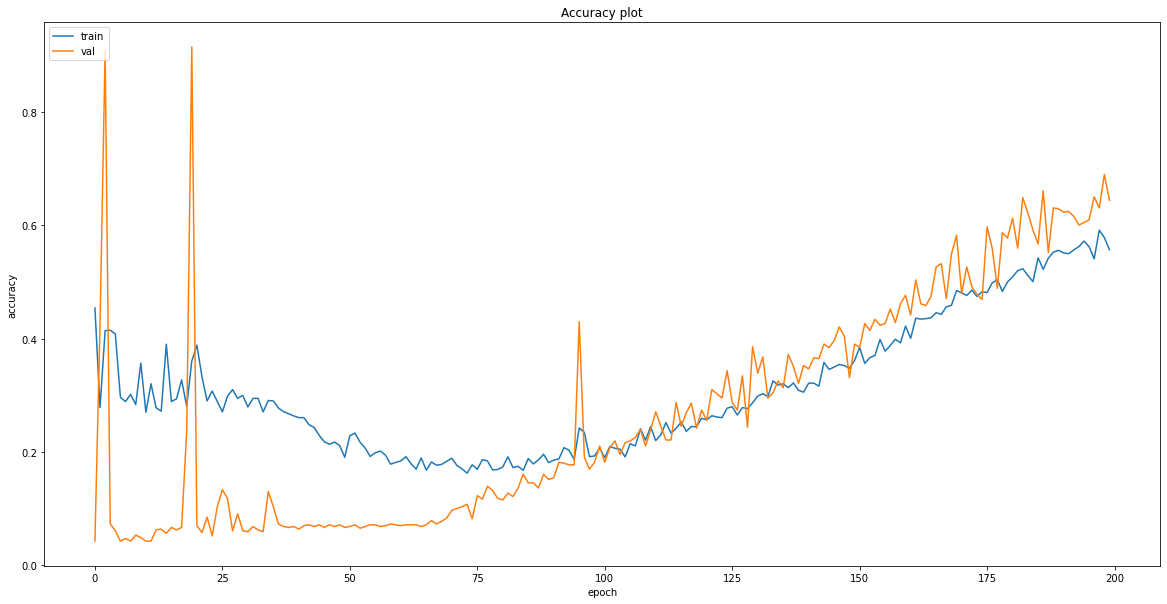

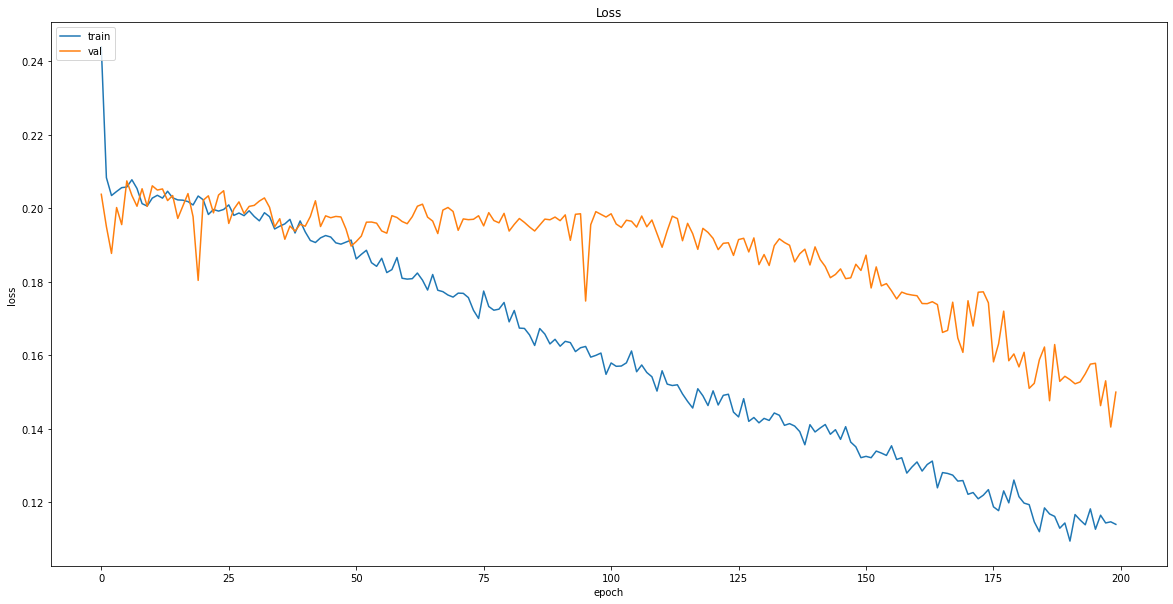

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
# Save model
model.save("models/{}".format('AAL_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/AAL_image_cnn_buy_hold_sell.model\assets
